In [15]:
## Loading package
# 过滤掉所有警告
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import anndata
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'
from utils import mclust_R
from model import DCCAE
from preprocess import preprocessing
from preprocess import fix_seed
import numpy as np


adata_modality_1 = sc.read_h5ad("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Spleen_1/adata_RNA.h5ad")
adata_modality_2 = sc.read_h5ad("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Spleen_1/adata_ADT.h5ad")

adata_modality_1.var_names_make_unique()
adata_modality_2.var_names_make_unique()

In [16]:
fix_seed(2024)
adata_modality_1, adata_modality_2 = preprocessing(adata_modality_1, adata_modality_2, 'SPOTS')
adata_modality_1.X = adata_modality_1.uns['INR']
adata_modality_2.obsm['X_pca'] = adata_modality_2.uns['INR']
sc.pp.pca(adata_modality_1)

SPOTS data preprocessing have done!
Dimensions after preprocessed adata_modal_1: (2568, 3000)
Dimensions after preprocessing adata_modal_2: (2568, 21)


In [17]:
## n_output = 21, n_DCCA = 15, epochs = 100, use_rep = use_rep[2]
## n_output = 21, n_DCCA = 15, epochs = 100, use_rep = use_rep[2]
n_output = 21
features1 = adata_modality_1.obsm['X_pca'].shape[1]  # Feature sizes
features2 = adata_modality_2.obsm['X_pca'].shape[1]
layers1 = [256, 256, n_output]  # nodes in each hidden layer and the output size
layers2 = [256, 256, n_output]

X = adata_modality_1.obsm['X_pca'].copy()
Y = adata_modality_2.obsm['X_pca'].copy()

use_rep = ['DCCAE_X', "DCCAE_Y", "DCCAE"]
n_DCCA = 10
epochs = 150
model = DCCAE(input_size1=features1, input_size2=features2, n_components=n_DCCA, layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=epochs)
model.fit([X, Y])
Xs_transformed = model.transform([X, Y])
adata_modality_1.obsm["DCCAE_X"] =  Xs_transformed[0]
adata_modality_2.obsm["DCCAE_Y"] =  Xs_transformed[1]
adata_modality_1.obsm["DCCAE"] = np.concatenate((adata_modality_1.obsm["DCCAE_X"], adata_modality_2.obsm["DCCAE_Y"]),axis=1)

Training Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 150/150 [00:19<00:00,  7.61it/s]


model training finished!


In [22]:
use_rep = ['DCCAE_X', 'DCCAE_Y', 'DCCAE']
mclust_R(adata_modality_1, used_obsm=use_rep[2], num_cluster=6)

fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 2568 × 3000
    obs: 'clusters_mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'INR', 'hvg', 'log1p', 'pca', 'clusters_mclust_colors'
    obsm: 'spatial', 'X_pca', 'DCCAE_X', 'DCCAE'
    varm: 'PCs'

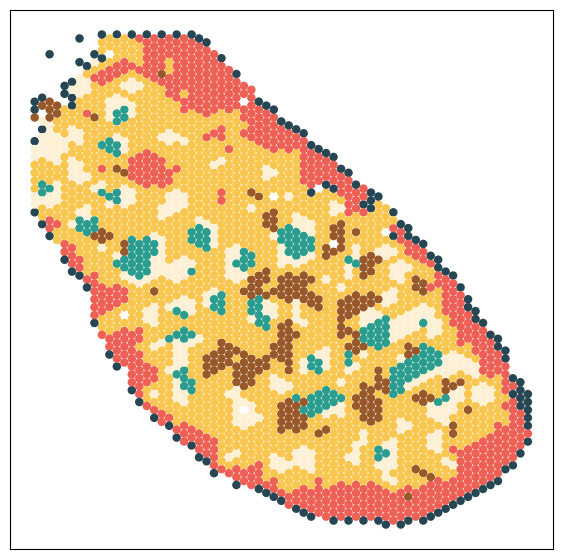

In [23]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
colors = [
    '#2a9d8f','#f9c74f',  '#fdf0d5','#99582a',  '#ee6055' ,'#264653'
]
sc.pl.embedding(adata_modality_1, basis='spatial', color='clusters_mclust', ax=ax, s=150, show=False, palette=colors)
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
# remove legend
ax.get_legend().remove()

In [12]:
## obs store the clustering results
## uns store the integrated embeddings
# adata_SpaKnit = anndata.AnnData()
adata_SpaKnit = anndata.AnnData()
adata_SpaKnit.obs['SpaKnit'] = adata_modality_1.obs['clusters_mclust']
adata_SpaKnit.obsm['SpaKnit'] = adata_modality_1.obsm['DCCAE']
adata_SpaKnit.obsm['spatial'] = adata_modality_1.obsm['spatial']
adata_SpaKnit.write_h5ad('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Mouse_Spleen_Replicate2.h5ad')

In [13]:
adata_SpaKnit

AnnData object with n_obs × n_vars = 2768 × 0
    obs: 'SpaKnit'
    obsm: 'SpaKnit', 'spatial'

In [14]:
## calculate the marker genes
sc.tl.dendrogram(adata_modality_1, groupby='clusters_mclust')
sc.tl.rank_genes_groups(adata_modality_1, groupby='clusters_mclust', use_raw=False)

rank_genes = sc.get.rank_genes_groups_df(adata_modality_1, group=None)
rank_genes.to_excel("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Visualization/Mouse_Spleen/Replicate2/" + 'Replicate2_marker_genes.xlsx', index=True)